In [1]:
import torch
from EcgStuffs.src.dpnet import dpnet_loader, conf

In [2]:
if torch.cuda.is_available():
    model = dpnet_loader.load() #load auto encoder model
else:
    model = dpnet_loader.load_cpu()

In [3]:
model

DPNet(
  (encoder): Encoder(
    (conv_0): Conv2d(1, 15, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (activation0): Tanh()
    (conv_1): Conv2d(15, 30, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (activation1): Tanh()
    (block_0): EncoderBlock(
      (conv2d_in): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (activation_in): Tanh()
      (batch_norm_in): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout_in): Dropout(p=0.2, inplace=False)
      (conv2d_out): Conv2d(30, 45, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (skip_con): Sequential(
        (0): Conv2d(30, 45, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (batch_norm_out): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_o

In [4]:
from sklearn.metrics import roc_curve, auc 

def plot_roc_curve(y, y_pred):
    # calculate the fpr, tpr, AUC and plot the ROC curve 
    '''
    input: 
    y: array-like contenente i valori dell'attributo target
    y_pred: array-like contenente le predizioni dell'attributo target
    output: None
    
    '''
    y = np.array(y)       #cast array-like in numpy array
    y_pred = np.array(y_pred)
    labels = np.unique(y)
    fpr, tpr, threshold = roc_curve(y, y_pred)
    #print(fpr, tpr)
    roc_auc = round(auc(fpr, tpr),2)
    
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC {}'.format(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot(labels, labels,'r--')
    plt.xlim(labels)
    plt.ylim(labels)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [5]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

def validate_model(y_trues, y_preds):

    TP = 0
    FP = 0
    TN = 0
    FN = 0
    idxs_missclassified = []
    for i, y_true in enumerate(y_trues):
        
        y_pred = y_preds[i]

        if y_true == 1: #"N":
            if y_pred == y_true:
                TN += 1
            else:
                FP += 1
                idxs_missclassified.append(i)
        else:
            if y_pred == y_true:
                TP += 1 
            else:
                FN += 1
                idxs_missclassified.append(i)


    acc = (TP+TN)/(TP+TN+FP+FN)
    if FN + TP != 0:
        TPR = TP/(FN+TP) #sensitivity 
        FNR = FN/(FN+TP)
        recall = TPR
    else: 
        TPR = None
        FNR = None 
        recall = None
    
    if TN+FP != 0:
        
        TNR = TN/(TN+FP) #specificity
        FPR = FP/(TN+FP)
    else: 
        TNR = None
        FPR = None 
    
    if TP+FP != 0:
        precision = TP/(TP+FP)
    else:
        precision = None
    
    if precision != 0 and recall != 0:
        f1 = 2*(1/((1/precision)+(1/recall)))
    else:
        f1 = None 
        
    cm = confusion_matrix(y_trues, y_preds)
    cr = classification_report(y_trues, y_preds)
    auc = roc_auc_score(y_trues, y_preds)
    metrics = {
        "accuracy": acc,
        "f1": f1,
        "cm": cm,
        "sensitivity": TPR,
        "specificity": TNR,
        "auc_score": auc,
        "precision": precision,
        "recall": recall,
        "report": cr,
        "predictions": y_preds,
        "idxs_missclassified": idxs_missclassified
    }

    plot_roc_curve(y_trues, y_preds)
    return metrics, "Accuracy: {} \n F1 score: {} \n Sensitivity: {} \n Specificity: {} \n ROC AUC score: {} \n Confusion Matrix: \n {} \n Classification Report: \n {} \n".format(acc, f1, TPR, TNR, auc, cm, cr)

In [6]:
import os
from EcgStuffs.src.windows.WindowingUtils import sliding_window
from EcgStuffs.src.pickleio.PickleIO import *
import numpy as np 
from torch.functional import F
import scipy
import csv

In [21]:
%cd ecg_data
%cd test
%cd new

C:\Users\Utente\Desktop\ECG Anomaly Detector Clean\ecg_data
C:\Users\Utente\Desktop\ECG Anomaly Detector Clean\ecg_data\test
C:\Users\Utente\Desktop\ECG Anomaly Detector Clean\ecg_data\test\new


In [73]:
done_files = []
not_done_files = []
data_path = os.getcwd()
for filename in os.listdir(data_path):
    if filename[len(filename)-4:] == '.mat':
        if os.path.isfile(filename[:len(filename)-4]+"_data.csv") and os.path.isfile(filename[:len(filename)-4]+"_labels.csv") and os.path.isfile(filename[:len(filename)-4]+"_labels.csv"):
            done_files.append(filename)
        else:
            not_done_files.append(filename)
not_done_files

[]

In [74]:
def mat2csv(matfilename):

    #load mat
    matfile = scipy.io.loadmat(matfilename)
    #extract only ecg data
    ecg_data = matfile['signals'][0,0]['multileadECG']
        
    #save ecg data into a .csv file
    filename = matfilename[:len(matfilename)-4]+"_data.csv"
    if not os.path.isfile(filename):
        np.savetxt(filename, ecg_data)
    
    #save ecg label into a .csv file
    ecg_labels = matfile["signals"][0, 0]["targets_SR_AF"][0, :]
    filename = matfilename[:len(matfilename)-4]+"_labels.csv"
    if not os.path.isfile(filename):
        np.savetxt(filename, ecg_labels)
        
    rpeaks = matfile["signals"][0, 0]["Rindices"]
    filename = matfilename[:len(matfilename)-4]+"_rpeaks.csv"
    if not os.path.isfile(filename):
        np.savetxt(filename, rpeaks)

In [75]:
for i, filename in enumerate(not_done_files):
    if filename[len(filename)-4:] == '.mat':
        print(i+1, "/", len(not_done_files), filename, end="\r")
        mat2csv(data_path+"\\"+filename)

In [76]:
y_trues = []
fs = 500 
nchs = 15 
reconstruction_errors = []
filepaths = []
filenames = os.listdir(data_path)
n = len(filenames)
all_windows = []
all_recons = []
map_windows = {}
map_windows_labels = {}
signals_all = {}
count = 0
for i, basename in enumerate(filenames):
    #print(basename)
    file_path = data_path + os.sep + basename
    if ".csv" in basename:
        
        if "data" in basename.split("_")[-1]:
            filename = basename[:len(basename)-4]
            map_windows[filename] = []
            map_windows_labels[filename] = {}
            with open(file_path, 'r') as csvdata:
                sniffer = csv.Sniffer()
                dialect = sniffer.sniff(csvdata.readline())
                delimiter = dialect.delimiter
            signal = np.genfromtxt(file_path, delimiter = delimiter, dtype = np.float32)
            signals_all[filename] = signal
            filepaths.append(file_path)
            print(i+1, "/", n, signal.shape, end="\r")
            nchs_data, n_record = signal.shape

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            interval = 1500
            interval2 = 2000
                
            windows = sliding_window(signal, interval2, stride=interval)

            windows = torch.from_numpy(np.array(windows))
            n_win = windows.shape[0]
            reconstruction_all = np.zeros((nchs, n_record))


            windows_batch_data = windows.clone().detach().unsqueeze(dim=0x1).to(device)
            filename_labels = data_path+ os.sep +filename[:-4]+"labels.csv"
            labels = np.loadtxt(filename_labels)
            
            filename_rpeaks = data_path+ os.sep +filename[:-4]+"rpeaks.csv"
            rpeaks = np.loadtxt(filename_rpeaks).flatten()
            map_windows_labels[filename][count] = []
            
            for i in range(0, n_win):
                
                if i == 0:
                    start = 0
                    end = interval
                else:
                    start += interval
                    end += interval

                rpeaks_in_window = []
                labels_in_window = []
                for j, rpeak in enumerate(rpeaks):
                    
                    if rpeak in np.arange(start, end, 1):
                        rpeaks_in_window.append(rpeak)
                        labels_in_window.append(labels[j])
                      
                if 1 in labels_in_window:
                    y_trues.append(1)
                else:
                    y_trues.append(0)
                
                #print(filename)
                batch_data = windows_batch_data[i, 0, :, :].reshape((1, 1, 15, interval2)).to(device)
                
                with torch.no_grad():
                    
                    all_windows.append(batch_data[0, 0, :, :interval2])  
                    reconstruction = model(batch_data)
                    reconstruction_errors.append((F.mse_loss(reconstruction[0, 0, :, :interval], batch_data[0, 0, :, :interval])).item())
                    recon_np = (reconstruction[0, 0, :, :interval].cpu().detach().numpy()).reshape(1, nchs, interval)
                    all_recons.append(reconstruction[0, 0, :, :interval])
                    
                    torch.cuda.empty_cache()
                    if end > n_record:
                        reconstruction_all[:, start:n_record] = recon_np[0, :, :interval-(end-n_record)] #TO FIX START AND END
                    else:
                        reconstruction_all[:, start:end] = recon_np[0, :, :interval]
            
                    torch.cuda.empty_cache()
                    
                map_windows[filename].append(count)
                map_windows_labels[filename][count] = labels_in_window
                count+=1

In [77]:
y_trues = np.array(y_trues)
np.unique(y_trues, return_counts=True)

(array([0, 1]), array([1279, 3630], dtype=int64))

In [78]:
channels = ["i", "ii", "iii", "aVR", "aVL", "aVF", "v1", "v2" ,"v3", "v4", "v5", "v6", "x", "y", "z"]

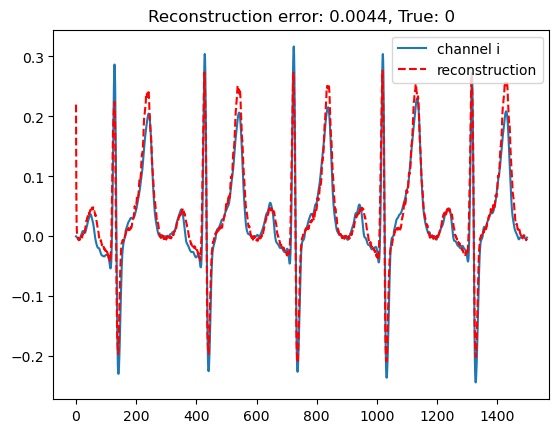

In [79]:
import matplotlib.pyplot as plt

idx_normal = np.argwhere(y_trues == 0)[0][0]
x_normal = all_windows[idx_normal][:, :interval].to(device)
recon_normal = all_recons[idx_normal].to(device)
reconstruction_error = F.mse_loss(recon_normal, x_normal).item()
y = y_trues[idx_normal]
ch = 0
plt.plot(x_normal[ch, :interval2].cpu().detach().numpy(), label = "channel {}".format(channels[ch]))
plt.plot(recon_normal[ch, :interval2].cpu().detach().numpy(), "--r", label = "reconstruction")
plt.title("Reconstruction error: {}, True: {}".format(round(reconstruction_error , 4), y_trues[idx_normal]))
plt.legend()

0.02996852993965149


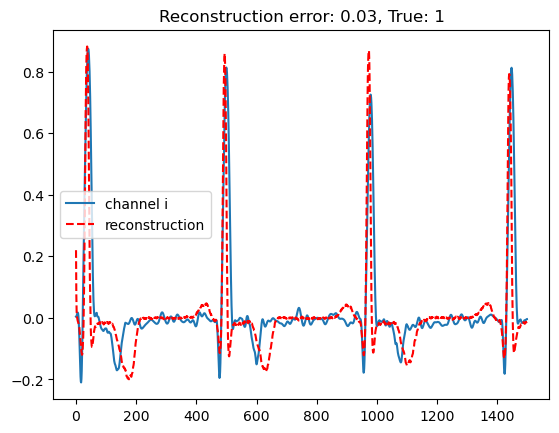

In [80]:
idx_abnormal = np.argwhere(y_trues == 1)[0][0]
x_abnormal = all_windows[idx_abnormal][:, :interval].to(device)
recon_abnormal = all_recons[idx_abnormal]
reconstruction_error = F.mse_loss(recon_abnormal, x_abnormal).item()
y = y_trues[idx_abnormal]
ch = 0
print(reconstruction_error)
plt.plot(x_abnormal[ch, :].cpu().detach().numpy(), label = "channel {}".format(channels[ch]))
plt.plot(recon_abnormal[ch, :].cpu().detach().numpy(), "--r", label = "reconstruction")
plt.title("Reconstruction error: {}, True: {}".format(round(reconstruction_error , 4), y_trues[idx_abnormal]))
plt.legend()

In [81]:
idx_normal, idx_abnormal

(0, 1279)

torch.Size([15, 1, 15, 2000])


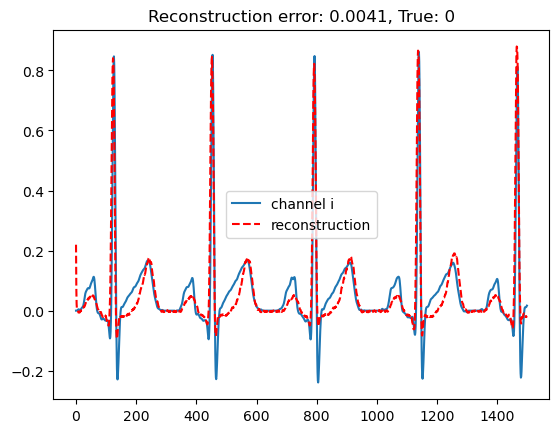

In [82]:
file_path = filepaths[5]
with open(file_path, 'r') as csvdata:
    sniffer = csv.Sniffer()
    dialect = sniffer.sniff(csvdata.readline())
    delimiter = dialect.delimiter
    
interval = 1500
interval2 = 2000

signal = np.genfromtxt(file_path, delimiter = delimiter, dtype = np.float32)
windows = sliding_window(signal, interval2, stride=interval)
windows = torch.from_numpy(np.array(windows))

ch = 0
idx = 2

y_trues_temp = []
temp =  windows_batch_data.shape[2] *  windows_batch_data.shape[3]
for i in range(0, n_win):
                
    if i == 0:
        start = 0
        end = interval
    else:
        start += interval
        end += interval

        rpeaks_in_window = []
        labels_in_window = []
        for j, rpeak in enumerate(rpeaks):
                    
            if rpeak in np.arange(start, end, 1):
                rpeaks_in_window.append(rpeak)
                labels_in_window.append(labels[j])
    
                        
            if 1 in labels_in_window:
                y_trues_temp.append(1)
            else:
                y_trues_temp.append(0)
                    
batch_data = windows.clone().detach().unsqueeze(dim=0x1).to(device)
reconstruction = model(batch_data)
print(reconstruction.shape)
reconstruction_error = F.mse_loss(reconstruction[0, 0, :, :interval], batch_data[0, 0, :, :interval]).item()
    
plt.plot(batch_data[0, 0, ch, :interval].cpu().detach().numpy(), label = "channel {}".format(channels[ch]))
plt.plot(reconstruction[0, 0, ch, :interval].cpu().detach().numpy(), "--r", label = "reconstruction")
plt.title("Reconstruction error: {}, True: {}".format(round(reconstruction_error , 4), y_trues_temp[idx]))
plt.legend()

In [83]:
np.unique(y_trues, return_counts=True)

(array([0, 1]), array([1279, 3630], dtype=int64))

In [84]:
from IPython.display import clear_output
from time import sleep

0.008699999999999979


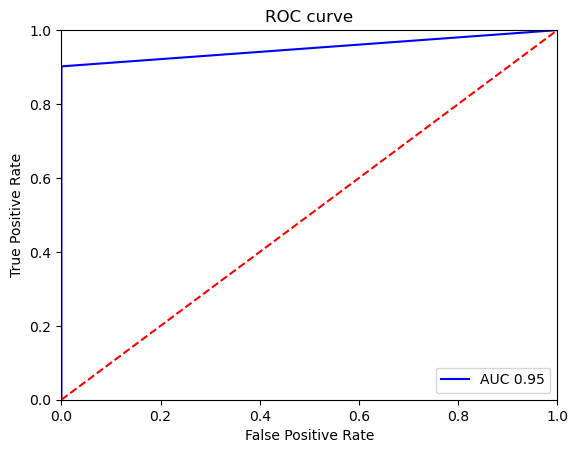

Accuracy: 0.9274801385210837 
 F1 score: 0.877831159917639 
 Sensitivity: 1.0 
 Specificity: 0.9019283746556473 
 ROC AUC score: 0.9509641873278236 
 Confusion Matrix: 
 [[1279    0]
 [ 356 3274]] 
 Classification Report: 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      1279
           1       1.00      0.90      0.95      3630

    accuracy                           0.93      4909
   macro avg       0.89      0.95      0.91      4909
weighted avg       0.94      0.93      0.93      4909
 

(array([0, 1]), array([1635, 3274], dtype=int64))


In [97]:
best_th = 0.0
best_auc = 0.0
normal_mse = []
anomalous_mse = []
count_decr = 0 

thresholds = np.arange(0.005, 0.009, 0.00005)#0.00001)
for j, threshold in enumerate(thresholds):
    y_preds = []
    
    for i, recon_error in enumerate(reconstruction_errors):
        
        if j == 0:
            if y_trues[i] == 0:
                normal_mse.append(recon_error)
            else:
                anomalous_mse.append(recon_error)
        
        if recon_error > threshold:
            y_preds.append(1)          #anomaly
        else:
            y_preds.append(0)
    
    sleep(0.1)
    clear_output(wait=True)
    print(threshold)
    metrics, to_print = validate_model(y_trues, y_preds)
    print(to_print)
    print(np.unique(y_preds, return_counts = True))
    auc_score = metrics["auc_score"]
    if auc_score > best_auc:
        best_th = threshold
        best_auc = auc_score
    if auc_score < best_auc:
        count_decr += 1
    if count_decr >= 50: 
        break

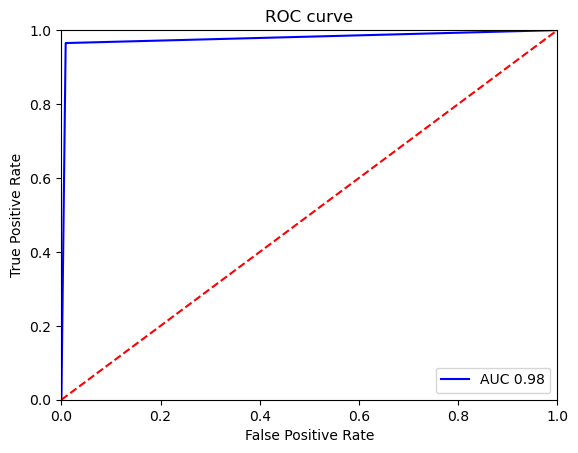

Accuracy: 0.9718883683031168 
 F1 score: 0.9483919222139119 
 Sensitivity: 0.9913995308835027 
 Specificity: 0.9650137741046831 
 ROC AUC score: 0.9782066524940929 
 Confusion Matrix: 
 [[1268   11]
 [ 127 3503]] 
 Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      1279
           1       1.00      0.97      0.98      3630

    accuracy                           0.97      4909
   macro avg       0.95      0.98      0.96      4909
weighted avg       0.97      0.97      0.97      4909
 



In [98]:
y_preds = []
for i, recon_error in enumerate(reconstruction_errors):
        
    if recon_error > best_th:
        y_preds.append(1)          #anomaly
    else:
        y_preds.append(0)

metrics, to_print = validate_model(y_trues, y_preds)
print(to_print)

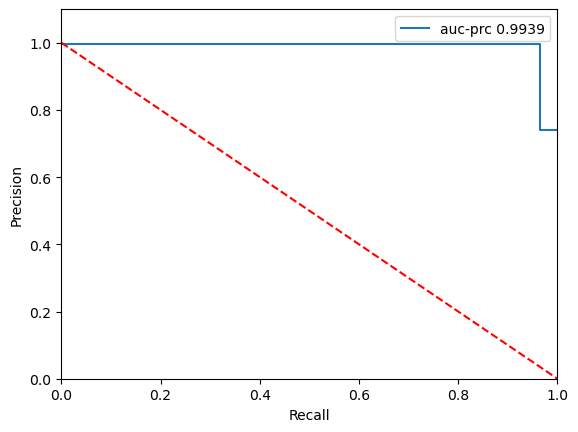

In [99]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(y_trues, y_preds)
auc_pr = auc(recall, prec)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(label="auc-prc {}".format(round(auc_pr, 4)))
plt.plot([0, 1], [1, 0], "--r")
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.legend()

In [100]:
best_th, best_auc

(0.006299999999999992, 0.9782066524940929)

In [101]:
import plotly.figure_factory as ff
import numpy as np


group_labels = ['Normal', 'Anomalous']

colors = ['slategray', 'magenta']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([normal_mse, anomalous_mse], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

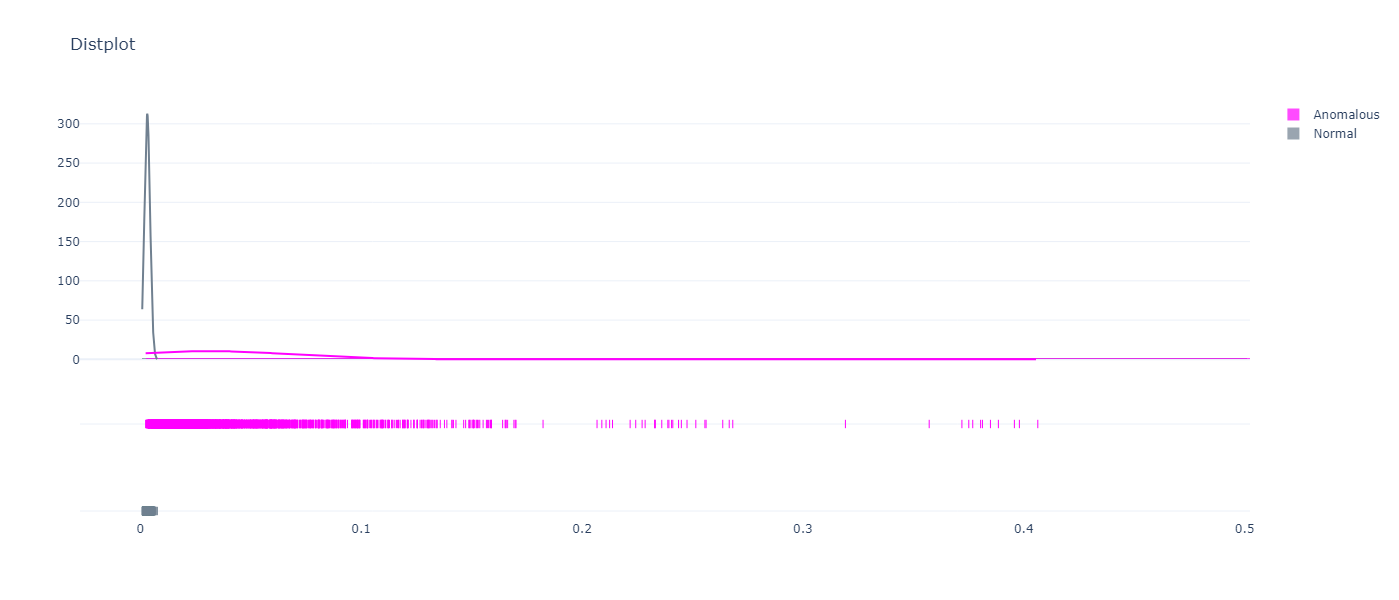

In [102]:
fig.update_layout(title_text='Distplot', template = "plotly_white", height = 600, width = 1200)
fig.show()

In [103]:
len(reconstruction_errors)

4909

In [104]:
map = {0: "Normal", 1: "Anomaly"}

In [106]:
np.argwhere(np.array(y_trues_temp) == 1)

array([[   7],
       [   8],
       [   9],
       [  10],
       [  11],
       [  12],
       [  13],
       [  14],
       [  15],
       [  16],
       [  17],
       [  18],
       [  19],
       [  20],
       [  21],
       [  22],
       [  23],
       [  24],
       [  25],
       [  26],
       [  27],
       [  28],
       [  29],
       [  30],
       [  31],
       [  32],
       [  33],
       [  34],
       [  35],
       [  36],
       [  37],
       [  38],
       [  39],
       [  40],
       [  41],
       [  42],
       [  43],
       [  44],
       [  45],
       [  46],
       [  47],
       [  48],
       [  49],
       [  50],
       [  51],
       [  52],
       [  53],
       [  54],
       [  55],
       [  56],
       [  57],
       [  58],
       [  59],
       [  60],
       [  61],
       [  62],
       [  63],
       [  64],
       [  65],
       [  66],
       [  67],
       [  68],
       [  69],
       [  70],
       [  71],
       [  72],
       [  

In [107]:
def isSignalAnomalous(patient, windows, threshold, test, n_anomalies_th = 1, device = "cuda", verbose = True):

    reconstruction_errors = []
    reconstruction_windows = torch.zeros_like((windows))
    interval = 1500
    interval2 = 2000
        
    nchs = 15
    n_record = windows.shape[0]*interval
    reconstruction_all = np.zeros((nchs, n_record))
    
    for i, batch_data in enumerate(windows):
        
        batch_data = batch_data.to(device)
        
        if i == 0:
            start = 0
            end = interval
        else:
            start += interval
            end += interval 
        
        #print(i, start, end, n_record)
        with torch.no_grad():
            reconstruction = model(batch_data)
            reconstruction_errors.append((F.mse_loss(reconstruction[0, 0, :, :interval], batch_data[0, 0, :, :interval])).item())
            reconstruction_windows[i, :, :] = reconstruction
            torch.cuda.empty_cache()
            if end > n_record:
                print(interval, start, end, n_record, (end-n_record))
                reconstruction_all[:, start:n_record] = recon_np[0, :, :interval2+(end-n_record)] #TO FIX START AND END
            else:
                reconstruction_all[:, start:end] = recon_np[0, :, :interval]
                
    predictions = []
    for recon_error in reconstruction_errors:
        if recon_error >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
            
    uqs, cnts = np.unique(predictions, return_counts = True)
    pred_cnts = {}

    for i, uq in enumerate(uqs):
        cnt = cnts[i]
        pred_cnts[uq] = cnt
    
    pred = 0# Normal
    if 1 in pred_cnts.keys():
        if pred_cnts[1] >= n_anomalies_th:
            pred = 1
    if verbose:
        print("Patient:", patient, "Target:", test,  "Prediction: ", pred, "Windows label:", uqs, "Windows counts:", cnts)
    
    reconstruction_all = torch.from_numpy(reconstruction_all).to(device)
    return reconstruction_all, pred, np.mean(recon_error)

In [108]:
y_test_patient = {patient: 1 if 1 in labels else 0 for patient, windows_labels in map_windows_labels.items() for window, labels in windows_labels.items()}
#y_test_patient

In [109]:
n = len(all_windows)
temp = torch.zeros((n, 1, 15, 2000))
for i, window in enumerate(all_windows):
    print(i+1, "/", n, end="\r")
    temp[i] = torch.unsqueeze(window, dim=0)
all_windows = temp
all_windows.shape

torch.Size([4909, 1, 15, 2000])

In [110]:
y_preds_patient = {}
patients_missclassified = []
recons_all = {}
recon_error_patients = {}
normal_mse_patient = []
abnormal_mse_patient = []

for i, (patient_signal, w) in enumerate(map_windows.items()):
    #print(i+1, "/", len(map_windows.keys()), patient_signal, end="\r")
    windows = all_windows[w] 
    windows = torch.unsqueeze(windows, dim=1)
    test = y_test_patient[patient_signal]
    recons_signal, pred, recon_error = isSignalAnomalous(patient_signal, windows, best_th, test, n_anomalies_th = 1) 
    recons_all[patient_signal] = recons_signal
    recon_error_patients[patient_signal] = recon_error
    y_preds_patient[patient_signal] = pred
    if test != pred:
        patients_missclassified.append(patient_signal)
    if test == 0:
        normal_mse_patient.append(recon_error)
    else:
        abnormal_mse_patient.append(recon_error)
#print(interval, end, n_record, interval-(end-n_record))

Patient: AF_20230710_211033_731635_data Target: 0 Prediction:  0 Windows label: [0] Windows counts: [13]
Patient: AF_20230710_211140_086767_data Target: 0 Prediction:  0 Windows label: [0] Windows counts: [21]
Patient: AF_20230710_211225_248776_data Target: 0 Prediction:  0 Windows label: [0] Windows counts: [19]
Patient: AF_20230710_211346_955545_data Target: 0 Prediction:  1 Windows label: [0 1] Windows counts: [10  1]
Patient: AF_20230710_211415_315551_data Target: 0 Prediction:  0 Windows label: [0] Windows counts: [14]
Patient: AF_20230710_211449_334625_data Target: 0 Prediction:  0 Windows label: [0] Windows counts: [15]
Patient: AF_20230710_211523_714721_data Target: 0 Prediction:  0 Windows label: [0] Windows counts: [14]
Patient: AF_20230710_211556_459645_data Target: 0 Prediction:  0 Windows label: [0] Windows counts: [14]
Patient: AF_20230710_211629_513852_data Target: 0 Prediction:  0 Windows label: [0] Windows counts: [17]
Patient: AF_20230710_211706_973554_data Target: 0 

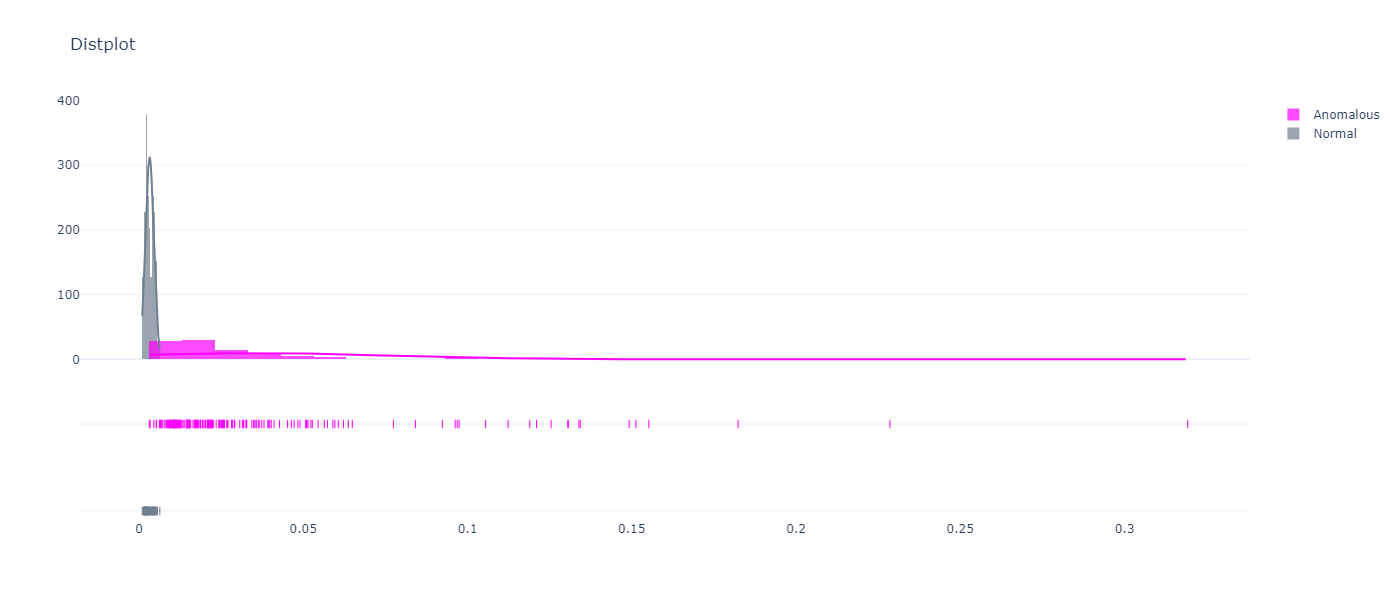

In [122]:
group_labels = ['Normal', 'Anomalous']

colors = ['slategray', 'magenta']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([normal_mse_patient, abnormal_mse_patient], group_labels, bin_size=0.0,
                         curve_type='normal', # override default 'kde'
                         colors=colors)
fig.update_layout(title_text='Distplot', template = "plotly_white", height = 600, width = 1200)
fig.show()

In [114]:
y_test_f = []
y_preds_f = []

for patient, test in y_test_patient.items():

    pred = y_preds_patient[patient]
    y_test_f.append(test)
    y_preds_f.append(pred)

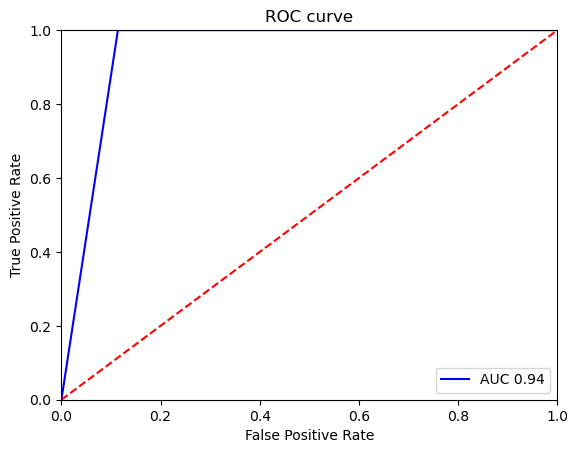

Accuracy: 0.9676258992805755 
 F1 score: 0.9395973154362416 
 Sensitivity: 0.8860759493670886 
 Specificity: 1.0 
 ROC AUC score: 0.9430379746835443 
 Confusion Matrix: 
 [[ 70   9]
 [  0 199]] 
 Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        79
           1       0.96      1.00      0.98       199

    accuracy                           0.97       278
   macro avg       0.98      0.94      0.96       278
weighted avg       0.97      0.97      0.97       278
 



In [115]:
rocauc, to_print = validate_model(y_test_f, y_preds_f)
print(to_print)

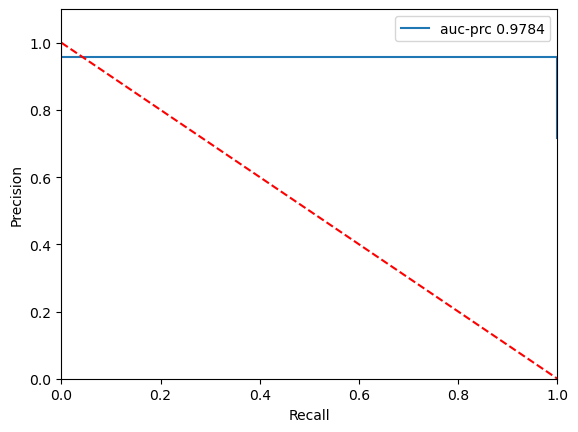

In [116]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(y_test_f, y_preds_f)
auc_pr = auc(recall, prec)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(label="auc-prc {}".format(round(auc_pr, 4)))
plt.plot([0, 1], [1, 0], "--r")
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.legend()

In [ ]:
prec, recall